# Market direction classifier
Note: 
* This model is fundamentally flawed due to the Efficients Markets Hypothesis (EMH) which states all available information is already priced into stock data. However, building and backtesting a model like this still provides valuable learning opportunities.
* This notebook is a work in progress 
* This notebook shouldn't be seen as actual trading advice to be applied in reality, more as a learning resource
* Transaction costs aren't taken into account in this model

In this work, I import historical candlestick data of EUR/USD exchange values from Twelve Data API. I then calculate returns over each time incriment by averaging Open-Close values. A set of 5 return values are then used to train a SVM classifier to predict the direction of market movements. The dataset is split into a train and test set to reduce overfitting. The test set is used to backtest performance of the model. Estimated returns (excluding transaction costs) are then calculated.

In [2]:
import requests
import numpy as np
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from config import API_KEY
from sklearn.metrics import accuracy_score


pd.set_option('display.max_columns',200)

In [3]:
url = "https://twelve-data1.p.rapidapi.com/time_series"

querystring = {"symbol":"EUR/USD",
               "interval":"15min",
               "outputsize":"5000",
               "format":"json"}

headers = {
	"X-RapidAPI-Key": API_KEY,
	"X-RapidAPI-Host": "twelve-data1.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

# print(response.json())

In [4]:
df_in = pd.json_normalize(response.json()['values'], 
                        meta=['datetime', 'open', 'high', 'low', 'close', ])
df_in[['open', 'high', 'low', 'close', ]] = df_in[['open', 'high', 'low', 'close',]].apply(pd.to_numeric)
df = df_in.copy().iloc[::-1].reset_index(drop=True)
df.drop(index=0)
df

,datetime,open,high,low,close
0,2023-09-21 22:30:00,1.0632,1.06370,1.0625,1.0635
1,2023-09-21 22:45:00,1.0635,1.06420,1.0633,1.0642
2,2023-09-21 23:00:00,1.0644,1.06480,1.0639,1.0645
3,2023-09-21 23:15:00,1.0645,1.06545,1.0640,1.0654
4,2023-09-21 23:30:00,1.0652,1.06600,1.0647,1.0656
...,...,...,...,...,...
4995,2023-12-05 07:45:00,1.0834,1.08355,1.0832,1.0834
4996,2023-12-05 08:00:00,1.0834,1.08370,1.0833,1.0835
4997,2023-12-05 08:15:00,1.0835,1.08370,1.0834,1.0836
4998,2023-12-05 08:30:00,1.0836,1.08370,1.0835,1.0835


Note this data doesn't include the bid-ask spread so we are essentially assuming 0 transaction cost
(An assumption of model - which is incorrect)

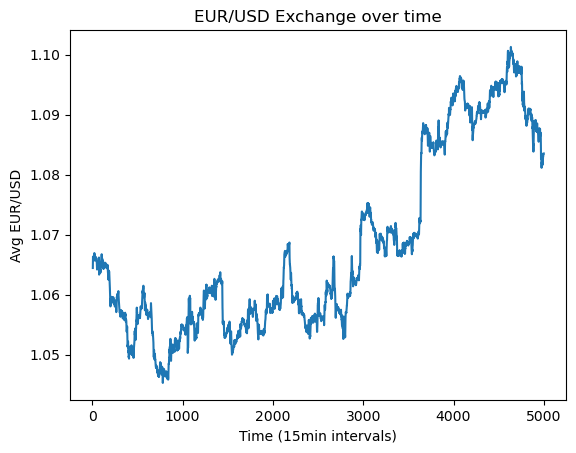

In [20]:
df['avg'] = df[['open','close']].mean(axis=1)
plt.plot(df['avg'])
plt.xlabel('Time (15min intervals)')
plt.ylabel('Avg EUR/USD')
plt.title('EUR/USD Exchange over time');

In [6]:
df['returns'] = np.log(df['avg'] / df['avg'].shift(1)) 
df.dropna(inplace=True)
df['direction'] = np.sign(df['returns']).astype(int)

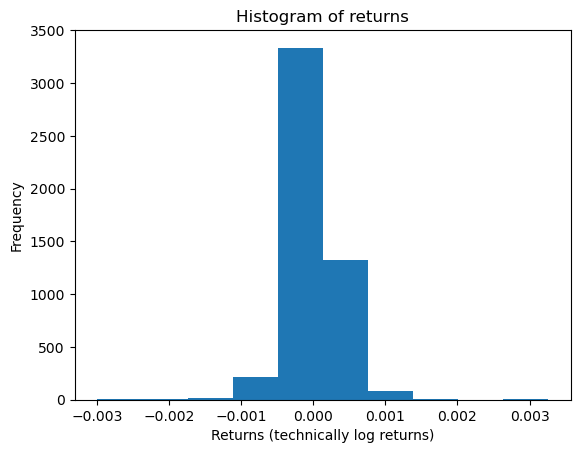

In [24]:
plt.hist(df['returns']);
plt.ylabel('Frequency')
plt.xlabel('Returns (technically log returns)')
plt.title('Histogram of returns');

In [8]:
def add_lagged_columns(df, column_to_lag, num_lags) -> pd.DataFrame:
    """
    Add lagged columns to a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column_to_lag (str): The column for which lagged columns are created.
        num_lags (int): The number of lagged columns to add.
    
    Returns:
        output_df: containing the direction and the lagged returns cols
    """
    cols = []
    for i in range(1, num_lags + 1):
        cols.append(f'{column_to_lag}_lag{i}')
        df[f'{column_to_lag}_lag{i}'] = df[column_to_lag].shift(i)
    return  cols

In [9]:
num_lags = 5
x_cols = add_lagged_columns(df,'returns', num_lags)
df.dropna(inplace=True)
df

,datetime,open,high,low,close,avg,returns,direction,returns_lag1,returns_lag2,returns_lag3,returns_lag4,returns_lag5
6,2023-09-22 00:00:00,1.0641,1.06480,1.0638,1.06480,1.064450,-0.000282,-1,-0.000610,0.000422,0.000470,0.000564,0.000470
7,2023-09-22 00:15:00,1.0648,1.06650,1.0648,1.06630,1.065550,0.001033,1,-0.000282,-0.000610,0.000422,0.000470,0.000564
8,2023-09-22 00:30:00,1.0662,1.06730,1.0661,1.06650,1.066350,0.000751,1,0.001033,-0.000282,-0.000610,0.000422,0.000470
9,2023-09-22 00:45:00,1.0665,1.06650,1.0657,1.06590,1.066200,-0.000141,-1,0.000751,0.001033,-0.000282,-0.000610,0.000422
10,2023-09-22 01:00:00,1.0659,1.06670,1.0655,1.06605,1.065975,-0.000211,-1,-0.000141,0.000751,0.001033,-0.000282,-0.000610
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2023-12-05 07:45:00,1.0834,1.08355,1.0832,1.08340,1.083400,0.000231,1,0.000092,0.000000,0.000323,0.000092,0.000323
4996,2023-12-05 08:00:00,1.0834,1.08370,1.0833,1.08350,1.083450,0.000046,1,0.000231,0.000092,0.000000,0.000323,0.000092
4997,2023-12-05 08:15:00,1.0835,1.08370,1.0834,1.08360,1.083550,0.000092,1,0.000046,0.000231,0.000092,0.000000,0.000323
4998,2023-12-05 08:30:00,1.0836,1.08370,1.0835,1.08350,1.083550,0.000000,0,0.000092,0.000046,0.000231,0.000092,0.000000


In [10]:
def fit_models(data):
    mfit = {model: models[model].fit(data[x_cols],data['direction'])
            for model in models.keys()}

def derive_positions(DF):
    for model in models.keys():
        DF['pos_' + model] = models[model].predict(DF[x_cols])

def evaluate_strats(data):
    sel = []
    for model in models.keys():
        col = 'strat_' + model
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')
    return sel


In [11]:
# train, test = train_test_split(df, test_size=0.5, shuffle=True, random_state=100)

split = int(len(df) * 0.5)
train = df.iloc[:split].copy()
test = df.iloc[split:].copy()

train = train.copy().sort_index()
test = test.copy().sort_index()

In [12]:
models = {
 'svm': SVC(C=1)
 }

In [13]:
fit_models(train)
derive_positions(test)
sel = evaluate_strats(test)
test[sel].sum().apply(np.exp)

returns      1.023762
strat_svm    1.278296
dtype: float64

In [14]:
print(f'SVM position accuracy in test set: {round(accuracy_score(test['direction'], test['pos_svm'])*100,ndigits=2)}%')

SVM position accuracy in test set: 60.75%


AttributeError: 'Axes' object has no attribute 'xlabel'

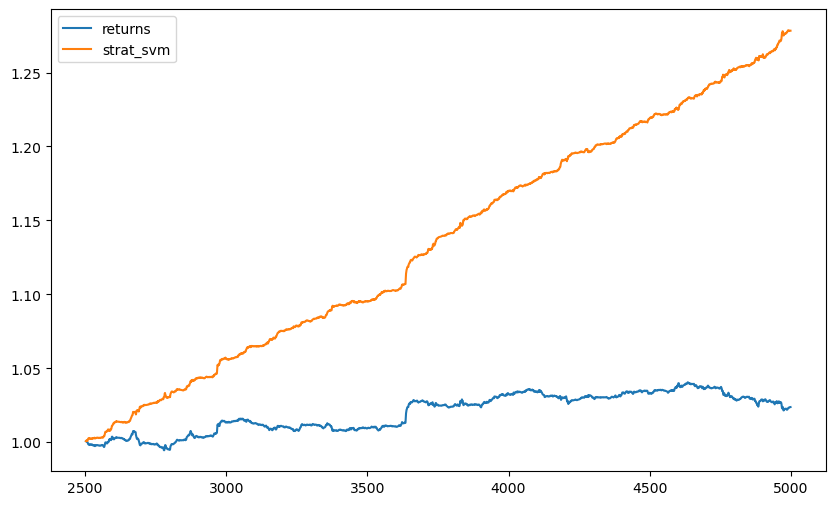

In [15]:
ax = test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
ax.xlabel('Trade ID - 1 represents a 15min period')

In [ ]:
my_column_changes = (test["pos_svm"].shift() != test["pos_svm"]).sum()
print(f'Total number of trades: {my_column_changes}')

Total number of trades: 1254


This looks somewhat suspicious, 27% returns within about 1 month of trading! Too good to be true?
* Is the model overfit?
* Is this just a chance month? > need to test on longer time periods
* Is the model even valid given EMH?
* Transaction costs required? 1254 trades with a small cost on each could add up.

## Leverage

In [ ]:
deltaTime = pd.Timedelta(pd.to_datetime(test.iloc[-1,0]) - pd.to_datetime(test.iloc[0,0])).days
print(f'Days of test set time period: {deltaTime}')

Days of test set time period: 36


This delta time includes times when the market is shut, however we are only roughly estimating here so I not a huge problem but should be accounted for in a more realistic model!

In [ ]:
test.iloc[0:97,0]

2503    2023-10-27 01:45:00
2504    2023-10-27 02:00:00
2505    2023-10-27 02:15:00
2506    2023-10-27 02:30:00
2507    2023-10-27 02:45:00
               ...         
2595    2023-10-28 00:45:00
2596    2023-10-28 01:00:00
2597    2023-10-28 01:15:00
2598    2023-10-28 01:30:00
2599    2023-10-28 01:45:00
Name: datetime, Length: 97, dtype: object

Rough estimates of annualised log mean return and variance are calculates below.

Note .mean() gives the geometric mean of 15min interval log retruns. Muiltiplying by 96 is because there are 96 15min intervals in a day. And forex trading occurs on all weekdays exlcuing bank holidays (252 trading days a year).

This mean and vol are used to calculate kelly creterion, f* = (mu - r)/sigma^2. I assume here the risk free return rate is 0 for simplicity.

In [ ]:
mean = test[['returns', 'strat_svm']].mean() * 96 * 252 
var = test[['returns','strat_svm']].var() * 96 * 252
vol  = var ** 0.5
estimated_kelly = mean/var
print(f'Mean for passive strat and SVM strat: \n{mean}\n')
print(f'Variance for passive strat and SVM strat: \n{var}\n')
print(f'Estimated leverage from Kelly Criterion: \n{estimated_kelly}')


Mean for passive strat and SVM strat: 
returns      0.304478
strat_svm    2.372135
dtype: float64

Variance for passive strat and SVM strat: 
returns      0.002557
strat_svm    0.002328
dtype: float64

Estimated leverage from Kelly Criterion: 
returns       119.065509
strat_svm    1018.796383
dtype: float64


The estimated optimal leverage from the Kelly Criterion is VERY HIGH, 1000. This is obvisouly unrealistics but is a consquence of the the SVM model itself being unrealistic (the annualised log returns are huge, 2.37!! and variance is very low).

This again is another symptom of the model likely being overfit or perhaps more just a reflection of the training data of the market itself being just a very lucky time to invest i.e. perhaps the training data time period picked is just a strong period in the market timeline. Collecting a wider range of historical data and training on that may bring the model back to reality.

## Problems with Kelly

The kelly crietrion is only valid FOR KNOWN probabilities! When trading we do not know probabilties with certainty, hence why the kelly fraction is not used in practice.

Typical leverage could be around half Kelly values. However the Kelly value calculated here is way too high, as discussed above, so I simply run the recreate 

returns      0.000013
strat_svm    0.000098
dtype: float64

# Risk Analysis

